In [105]:
# ===========================
# Cell 0 — Config
# ===========================
# 2 stage bundles root
STAGE_2_RUNS_ROOT = "Jacob"                       # Jacob/<dataset>/...

# Monolith bundles root
MONOLITH_RUNS_ROOT = "jacobs_examples/qae_runs" # jacobs_examples/qae_runs/<dataset>/...

# Sidekick bundles root
SIDEKICK_RUNS_ROOTS = ["Artur/qae_runs", "Artur"]  # Artur/qae_runs/<dataset>/... OR Artur/<dataset>/...

# Datasets to evaluate
DATASETS = ["mackey_glass_tau17_n200", "mackey_glass_tau30_n200"]

# Where the raw data are (for windowing & scaling)
LOG_NAME   = "jacobs_examples/aintern"
DATA_ROOT  = f"{LOG_NAME}/data"

# Fallbacks if bundle misses these
FALLBACK_SIGMA = 0.20
FALLBACK_SEED  = 99123

# Output directory for CSVs & plots
FRAMEWORK_OUT = "qae_eval_framework"

# Toggle plots
MAKE_PLOTS = True

# Optional path filter when scanning runs (keep None to include everything)
RUN_PATH_FILTER = None

In [106]:
# ===========================
# Cell 1 — Imports & core utilities
# ===========================
import os, json, re, sys, time
from pathlib import Path
from typing import Dict, Any, Tuple, List, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pennylane as qml
from pennylane import numpy as pnp

# Repo utils
sys.path.append('.'); sys.path.append('..')
from qae_utils.Files import read_json_file, read_ts_file, create_folder_if_needed
from qae_utils.Window import ts_wind_make, ts_wind_split, ts_wind_flatten_avg, ts_add_noise

Path(FRAMEWORK_OUT).mkdir(parents=True, exist_ok=True)

def find_datasets_under(root: str) -> List[str]:
    if not Path(root).exists():
        return []
    return sorted([p.name for p in Path(root).iterdir() if p.is_dir()])

def load_dataset_series(data_id: str) -> Tuple[np.ndarray, Dict[str, float]]:
    """Load y plus {scale_low, scale_high}, robust to working directory."""
    base_candidates = [
        Path(DATA_ROOT),
        Path("aintern/data"),
        Path("jacobs_examples/aintern/data"),
        Path("../aintern/data"),
        Path("../jacobs_examples/aintern/data"),
        Path("../../aintern/data"),
        Path("../../jacobs_examples/aintern/data"),
    ]
    tried = []
    for base in base_candidates:
        folder = (base / data_id).resolve()
        info_p = folder / "info.json"
        y_p    = folder / "y_org.arr"
        if info_p.exists() and y_p.exists():
            info = read_json_file(str(info_p))
            y    = read_ts_file(str(y_p))
            return np.asarray(y), dict(
                scale_low=float(info["scale_low"]),
                scale_high=float(info["scale_high"]),
            )
        tried.append(str(folder))

    for root in [Path.cwd(), Path.cwd().parent]:
        for folder in root.rglob(data_id):
            if not folder.is_dir():
                continue
            info_p = folder / "info.json"
            y_p    = folder / "y_org.arr"
            if info_p.exists() and y_p.exists():
                info = read_json_file(str(info_p))
                y    = read_ts_file(str(y_p))
                return np.asarray(y), dict(
                    scale_low=float(info["scale_low"]),
                    scale_high=float(info["scale_high"]),
                )
            tried.append(str(folder))

    raise FileNotFoundError(
        f"Missing dataset files for {data_id}. Searched:\n  - " + "\n  - ".join(tried)
    )

def arch_from_tag(tag: str) -> Tuple[int,int,int]:
    m = re.match(r"(\d+)q_(\d+)l_(\d+)t", tag)
    if not m:
        raise ValueError(f"Bad arch_tag: {tag}")
    return int(m[1]), int(m[2]), int(m[3])

def windows_from_seed(y_vec, sigma, seed, wind_size, wind_step, split, scale_low, scale_high):
    """Fixed-seed noise injection; no clipping of the series prior to angle mapping."""
    y_noisy = ts_add_noise(
        y_vec, noise=sigma, noise_type='normal', clip=False,
        range_low=scale_low, range_high=scale_high, seed=int(seed)
    )
    win_clean = ts_wind_make(y_vec,   wind_size, wind_step)
    win_noisy = ts_wind_make(y_noisy, wind_size, wind_step)
    X_ts = np.array([i*wind_step for i in range(len(win_clean))])
    _, tr_c, _, te_c = ts_wind_split(X_ts, win_clean, split)
    _, tr_n, _, te_n = ts_wind_split(X_ts, win_noisy, split)
    return np.asarray(tr_c), np.asarray(tr_n), np.asarray(te_c), np.asarray(te_n)

def flatten_avg(windows, wind_step):
    return ts_wind_flatten_avg(np.asarray(windows), wind_step)

def mse(a, b):
    a = np.asarray(a); b = np.asarray(b)
    return float(np.mean((a - b) ** 2))

In [107]:
# ===========================
# Cell 2 — z->values, angles, param counts
# ===========================
# Differentiation selector (kept for completeness; eval is forward-only)
def choose_diff_method(reset_mode: str, requested: str = "adjoint") -> str:
    r = (reset_mode or "").lower()
    if r == "swap" and requested == "adjoint":
        return "adjoint"
    return "best"

# --- Inverse mappings ---
def map_z_to_value_mine(z_all, scale_low, scale_high):
    """Arccos mapping used in your earlier two-stage / 3-stage baselines."""
    z = np.clip(np.asarray(z_all), -0.999999, 0.999999)
    v01 = np.arccos(z) / np.pi
    return v01 * (scale_high - scale_low) + scale_low

def map_z_to_value_mentor_identity(z_all):
    return np.asarray(z_all)

def map_z_to_value_expZ(z_all, scale_low, scale_high):
    """Sidekick mapping: (z+1)/2 → [low, high]."""
    z = np.clip(np.asarray(z_all, dtype=float), -0.999999, 0.999999)
    v01 = (z + 1.0) * 0.5
    return v01 * (scale_high - scale_low) + scale_low

# --- values → angles (Sidekick) ---
SIDEKICK_CLIP_ANGLES = True
def values_to_angles_sidekick(vals, scale_low, scale_high, clip=SIDEKICK_CLIP_ANGLES):
    v = np.asarray(vals, dtype=float)
    v01 = (v - scale_low) / max(scale_high - scale_low, 1e-12)
    if clip:
        v01 = np.clip(v01, 0.0, 1.0)
    return v01 * np.pi

# --- parameter counting helpers ---
def _count_params_monolithic(n_qubits_or_wires: int, L: int, rot: str) -> Tuple[int, int, int]:
    per_wire = 1 if str(rot).lower().strip() == "ry" else 3
    enc = L * n_qubits_or_wires * per_wire
    dec = L * n_qubits_or_wires * per_wire
    return enc + dec, enc, dec

def _count_params_two_like(n_qubits: int, L: int) -> Tuple[int, int, int]:
    """Encoder+decoder each with RX/RY/RZ → 3 params per qubit per layer."""
    per_wire = 3
    a = L * n_qubits * per_wire
    b = L * n_qubits * per_wire
    return a + b, a, b

In [108]:
def _shape_layers_full(n_layers, n_wires, rot='Rxyz'):
    if str(rot).lower() == 'ry':
        return qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
    else:
        return qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)

def _entangler_full(wires, weights, rot='Rxyz'):
    if str(rot).lower() == 'ry':
        qml.BasicEntanglerLayers(weights, wires=wires, rotation=qml.RY)
    else:
        qml.StronglyEntanglingLayers(weights, wires=wires)

def build_full_qae_qnode_eval(
    n_qubits, n_latent, n_trash, n_extra, L, rot, reset_mode, device="lightning.qubit"
):
    """
    Forward-only eval version (NumPy, no grads).
    """
    wires = list(range(n_latent + n_trash + n_extra))
    need_anc = (n_trash + n_extra) if (str(reset_mode).lower() == "swap") else 0
    ancillas = list(range(len(wires), len(wires)+need_anc))
    dev = qml.device(device, wires=len(wires)+need_anc, shots=None)

    data_wires = wires[:n_latent+n_trash]
    anz_wires  = wires

    enc_shape  = _shape_layers_full(L, len(anz_wires), rot=rot)
    dec_shape  = enc_shape

    @qml.qnode(dev, interface="numpy", diff_method=None)
    def qnode(weights, inputs_raw):
        enc_w = np.asarray(weights[:L]).reshape(enc_shape)
        dec_w = np.asarray(weights[L:]).reshape(dec_shape)

        # "raw" encoding (kept to match legacy monolithic bundles)
        for i, w in enumerate(data_wires):
            theta = inputs_raw[i] if i < len(inputs_raw) else 0.0
            qml.RY(theta, wires=w)

        qml.Barrier(wires)
        _entangler_full(anz_wires, enc_w, rot=rot)

        qml.Barrier(wires)
        if str(reset_mode).lower() == "swap":
            anc_tr = ancillas[:n_trash]
            anc_ex = ancillas[n_trash:n_trash+n_extra]
            for t, a in zip(data_wires[n_latent:], anc_tr):
                qml.SWAP(wires=[t, a])
            for e, a in zip(wires[n_latent+n_trash:], anc_ex):
                qml.SWAP(wires=[e, a])
        else:
            for w in data_wires[n_latent:]: qml.measure(w, reset=True)
            for w in wires[n_latent+n_trash:]: qml.measure(w, reset=True)
        qml.Barrier(wires)

        qml.adjoint(_entangler_full)(anz_wires, dec_w, rot=rot)
        qml.Barrier(wires)

        return [qml.expval(qml.PauliZ(w)) for w in data_wires]

    return qnode

In [109]:
# ===========================
# Cell 4 — Two-stage & Sidekick
# ===========================
# ---------- Two-stage (eval-only) ----------
def build_half_qae_handles_eval(
    n_qubits, n_latent, n_trash, L, reset_mode, device="lightning.qubit"
):
    need_anc = n_trash if (str(reset_mode).lower() == "swap") else 0
    dev = qml.device(device, wires=n_qubits + need_anc, shots=None)
    trash_wires = list(range(n_latent, n_qubits))
    anc_wires   = list(range(n_qubits, n_qubits+need_anc))

    def encoder_template(flat_params):
        params = np.asarray(flat_params).reshape((L, n_qubits, 3))
        for l in range(L):
            for q in range(n_qubits):
                qml.RX(params[l,q,0], wires=q)
                qml.RY(params[l,q,1], wires=q)
                qml.RZ(params[l,q,2], wires=q)
            for q in range(n_qubits-1): qml.CNOT(wires=[q, q+1])
            qml.CNOT(wires=[n_qubits-1, 0])

    def embed_input_pi(x, scale_low, scale_high):
        xn = (np.asarray(x) - scale_low) / max(scale_high - scale_low, 1e-12)
        for i, v in enumerate(xn):
            qml.RY(v * np.pi, wires=i)

    @qml.qnode(dev, interface="numpy", diff_method=None)
    def denoiser_qnode_all(flat_params, phi_stage1, x_noisy, scale_low, scale_high):
        embed_input_pi(x_noisy, scale_low, scale_high)
        encoder_template(flat_params)

        if n_trash > 0:
            if str(reset_mode).lower() == "swap":
                for t, a in zip(trash_wires, anc_wires):
                    qml.SWAP(wires=[t, a])
            else:
                for w in trash_wires: qml.measure(w, reset=True)

        theta_fixed = np.asarray(phi_stage1).reshape((L, n_qubits, 3))

        def enc_body(theta):
            for l in range(L):
                for q in range(n_qubits):
                    qml.RX(theta[l,q,0], wires=q)
                    qml.RY(theta[l,q,1], wires=q)
                    qml.RZ(theta[l,q,2], wires=q)
                for q in range(n_qubits-1): qml.CNOT(wires=[q, q+1])
                qml.CNOT(wires=[n_qubits-1, 0])

        qml.adjoint(enc_body)(theta_fixed)
        return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]

    return dict(denoiser=denoiser_qnode_all)

# ---------- Sidekick (eval-only; ψ → SWAP reset(trash) → φ† → X → ⟨Z⟩) ----------
def _shape_layers_SEL(n_layers, n_wires, rot='Rxyz'):
    return (qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
            if str(rot).lower() == 'ry'
            else qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires))

def _entangler_SEL(wires, weights, rot='Rxyz'):
    if str(rot).lower() == 'ry':
        qml.BasicEntanglerLayers(weights, wires=wires, rotation=qml.RY)
    else:
        qml.StronglyEntanglingLayers(weights, wires=wires)

def build_sidekick_full_forward_qnode_eval(n_latent, n_trash, L, rot='Rxyz', device="lightning.qubit"):
    """
    Wires layout:
      data_wires = latent + trash  (size n_latent + n_trash)
      zero_wires = trash zeros     (size n_trash)
      total wires = n_latent + 2*n_trash
    """
    n_data  = n_latent + n_trash
    n_wires = n_latent + 2*n_trash
    dev = qml.device(device, wires=n_wires, shots=None)

    data_wires = list(range(n_data))
    lat_wires  = data_wires[:n_latent]
    trash_w    = data_wires[n_latent:]
    zero_wires = list(range(n_data, n_wires))

    enc_shape = _shape_layers_SEL(L, len(data_wires), rot=rot)

    @qml.qnode(dev, interface="numpy", diff_method=None)
    def qnode(psi_enc, phi_dec, x_values, scale_low, scale_high):
        # values → angles (RY), clipped to [0, π]
        thetas = values_to_angles_sidekick(x_values, scale_low, scale_high, clip=SIDEKICK_CLIP_ANGLES)
        for i, w in enumerate(data_wires):
            qml.RY(thetas[i] if i < len(thetas) else 0.0, wires=w)

        # ψ on data wires
        _entangler_SEL(data_wires, np.asarray(psi_enc).reshape(enc_shape), rot=rot)

        # SWAP reset: move trash → zeros
        for t, z in zip(trash_w, zero_wires):
            qml.SWAP(wires=[t, z])

        # φ† on data wires (same template as encoder but adjoint)
        phi_shape = _shape_layers_SEL(L, len(data_wires), rot=rot)
        _phi = np.asarray(phi_dec).reshape(phi_shape)
        qml.adjoint(_entangler_SEL)(data_wires, _phi, rot=rot)

        # X flip
        for w in data_wires:
            qml.PauliX(wires=w)

        # readout expZ on all data wires
        return [qml.expval(qml.PauliZ(w)) for w in data_wires]

    return qnode

In [110]:
# ===========================
# Cell 5 — eval_bundle
# ===========================
def classify_model_type(schema_name: str, reset_mode: Optional[str]) -> str:
    """
    sidekick_qae    → sidekick_bundle
    monolithic_qae  → full_qae_bundle
    two_stage_qae   → half_qae_bundle (any reset_mode)
    """
    s = (schema_name or "").strip().lower()
    if "sidekick" in s:
        return "sidekick_qae"
    if "full_qae" in s:
        return "monolithic_qae"
    if "half_qae" in s:
        return "two_stage_qae"
    return "unknown"

def eval_bundle(bundle_path: Path, y_vec: np.ndarray, scale_low: float, scale_high: float):
    with open(bundle_path, "r", encoding="utf-8") as f:
        B = json.load(f)

    schema = (B.get("schema", {}) or {}).get("name", "unknown")
    data   = B.get("dataset", {})
    env    = B.get("environment", {})
    arch   = B.get("architecture", {})
    run    = B.get("run", {})
    pars   = B.get("parameters", {})

    device = (env.get("device")
              or env.get("backend")
              or env.get("stage3_backend")
              or "lightning.qubit")
    reset_mode = (env.get("reset_mode") or env.get("RESET_MODE") or "swap")

    model_type = classify_model_type(schema, reset_mode)
    # Human-readable label for summaries; keeps Cell 6 printing useful
    MODEL_LABEL = {
        "monolithic_qae": "Monolithic QAE",
        "two_stage_qae":  "Two-stage QAE",
        "sidekick_qae":   "Sidekick QAE",
    }.get(model_type, model_type)

    data_id   = data.get("id", "UNKNOWN")
    wind_size = int(data.get("window_size", arch.get("n_qubits", 0)))
    wind_step = int(data.get("window_step", 1))
    split     = float(data.get("split", 0.75))

    n_qubits = int(arch.get("n_qubits", wind_size))
    n_latent = int(arch.get("n_latent", 0))
    n_trash  = int(arch.get("n_trash",  0))
    n_extra  = int(arch.get("n_extra",  0))
    n_wires_mono = n_latent + n_trash + n_extra

    rot      = arch.get("rot", "Rxyz")
    L     = int(run.get("layer", 1))
    inst  = int(run.get("instance_id", -1))
    sigma = float(run.get("sigma_eval", FALLBACK_SIGMA))
    seed  = int(run.get("test_seed_fixed", FALLBACK_SEED))

    arch_tag = f"{n_qubits}q_{n_latent}l_{n_trash}t"

    # Windows (fixed seed, no clip)
    tr_c, tr_n, te_c, te_n = windows_from_seed(
        y_vec, sigma, seed, wind_size, wind_step, split, scale_low, scale_high
    )

    # Build + run
    if model_type == "sidekick_qae":
        phi = np.asarray(pars.get("phi", []), dtype=float)
        psi = np.asarray(pars.get("psi", []), dtype=float)
        qnode = build_sidekick_full_forward_qnode_eval(
            n_latent=n_latent, n_trash=n_trash, L=L, rot=rot, device=device
        )
        def run_windows(W):
            outs=[]
            for w in W:
                z = qnode(psi, phi, np.asarray(w, dtype=float), scale_low, scale_high)
                v = map_z_to_value_expZ(z, scale_low, scale_high)  # (z+1)/2 mapping
                outs.append(v[:(n_latent + n_trash)])
            return np.stack(outs)
        n_total, n_phi, n_psi = _count_params_two_like(n_latent + n_trash, L)
        n_enc = n_dec = None

    elif model_type == "monolithic_qae":
        weights = np.asarray(pars.get("weights", []), dtype=float)
        qnode = build_full_qae_qnode_eval(
            n_qubits, n_latent, n_trash, n_extra, L, rot, reset_mode, device=device
        )
        def run_windows(W):
            outs=[]
            for w in W:
                z = qnode(weights, np.asarray(w, dtype=float))  # ⟨Z⟩ on data wires
                v = map_z_to_value_identity(z)                  # legacy monolithic mapping
                outs.append(v)
            return np.stack(outs)
        n_total, n_enc, n_dec = _count_params_monolithic(n_wires_mono or n_qubits, L, rot)
        n_phi = n_psi = None

    elif model_type == "two_stage_qae":
        phi = np.asarray(pars.get("phi", []), dtype=float)
        psi = np.asarray(pars.get("psi", []), dtype=float)
        H = build_half_qae_handles_eval(
            n_qubits, n_latent, n_trash, L, reset_mode, device=device
        )
        denoise = H["denoiser"]
        def run_windows(W):
            outs=[]
            for w in W:
                z = denoise(psi, phi, np.asarray(w, dtype=float), scale_low, scale_high)
                v = map_z_to_value_arccos(z, scale_low, scale_high)
                outs.append(v[:n_qubits])
            return np.stack(outs)
        n_total, n_phi, n_psi = _count_params_two_like(n_qubits, L)
        n_enc = n_dec = None

    else:
        raise ValueError(f"Unknown bundle/schema in {bundle_path} (schema={schema})")

    # Execute & score
    tr_hat = run_windows(tr_n); te_hat = run_windows(te_n)

    tr_pure = flatten_avg(tr_c, wind_step); te_pure = flatten_avg(te_c, wind_step)
    tr_noi  = flatten_avg(tr_n, wind_step); te_noi  = flatten_avg(te_n, wind_step)
    tr_hatf = flatten_avg(tr_hat, wind_step); te_hatf = flatten_avg(te_hat, wind_step)

    mse_tr_noise = mse(tr_pure, tr_noi)
    mse_te_noise = mse(te_pure, te_noi)
    mse_tr_rec   = mse(tr_pure, tr_hatf)
    mse_te_rec   = mse(te_pure, te_hatf)

    imp_tr = 100.0 * (1.0 - mse_tr_rec / max(mse_tr_noise, 1e-12))
    imp_te = 100.0 * (1.0 - mse_te_rec / max(mse_te_noise, 1e-12))

    out = dict(
        dataset=data_id,
        model_type=model_type,
        author=MODEL_LABEL,  # NOTE: author now holds a human-readable model type label
        schema=schema,
        bundle=str(bundle_path),
        arch_tag=arch_tag,
        layer=L,
        instance=inst,
        reset_mode=str(reset_mode),
        rot=str(rot),
        sigma=float(sigma),
        seed=int(seed),
        wind_size=wind_size,
        wind_step=wind_step,
        mse_train_noise=mse_tr_noise,
        mse_train_recovered=mse_tr_rec,
        imp_train_pct=imp_tr,
        mse_test_noise=mse_te_noise,
        mse_test_recovered=mse_te_rec,
        imp_test_pct=imp_te,
        n_params_total=int(n_total),
        n_params_encoder=(None if n_enc is None else int(n_enc)),
        n_params_decoder=(None if n_dec is None else int(n_dec)),
        n_params_phi=(None if n_phi is None else int(n_phi)),
        n_params_psi=(None if n_psi is None else int(n_psi)),
    )
    return out

In [111]:
# ===========================
# Cell 6 — Evaluate all bundles and write CSVs
# ===========================
if DATASETS is None:
    DATASETS = find_datasets_under(STAGE_2_RUNS_ROOT)
    print("Auto-discovered datasets:", DATASETS)

ALL_RESULTS = {ds: [] for ds in DATASETS}

for ds in DATASETS:
    try:
        y, meta = load_dataset_series(ds)
    except Exception as e:
        print(f"[Skip {ds}] {e}")
        continue

    scale_low, scale_high = meta["scale_low"], meta["scale_high"]
    bundles = scan_bundles_for_dataset(ds, path_filter=RUN_PATH_FILTER)
    if not bundles:
        print(f"[{ds}] No bundles found under provided roots.")
        continue

    print(f"[{ds}] Found {len(bundles)} bundles. Evaluating…")
    for b in bundles:
        try:
            row = eval_bundle(b, y, scale_low, scale_high)
            ALL_RESULTS[ds].append(row)
        except Exception as e:
            print(f"  - Failed on {b}: {e}")

    df = pd.DataFrame(ALL_RESULTS[ds]).sort_values(
        ["model_type","arch_tag","layer","instance","bundle"]
    )
    out_csv = Path(FRAMEWORK_OUT) / f"eval_all_{ds}.csv"
    df.to_csv(out_csv, index=False)
    print(f"[{ds}] Wrote → {out_csv} (rows={len(df)})")

    # quick summary
    if not df.empty:
        print(df["author"].value_counts(dropna=False).to_string())

    for mt in ["monolith_qae", "two_stage_qae", "sidekick_qae"]:
        sub = df[df["model_type"] == mt].copy()
        sub_csv = Path(FRAMEWORK_OUT) / f"eval_all_{ds}_{mt}.csv"
        if not sub.empty:
            sub.to_csv(sub_csv, index=False)
            print(f"[{ds}] {mt} CSV → {sub_csv} (rows={len(sub)})")
        else:
            print(f"[{ds}] {mt} CSV → (no rows)")

[mackey_glass_tau17_n200] Found 120 bundles. Evaluating…
[mackey_glass_tau17_n200] Wrote → qae_eval_framework/eval_all_mackey_glass_tau17_n200.csv (rows=120)
author
Monolithic QAE    40
Sidekick QAE      40
Two-stage QAE     40
[mackey_glass_tau17_n200] monolith_qae CSV → (no rows)
[mackey_glass_tau17_n200] two_stage_qae CSV → qae_eval_framework/eval_all_mackey_glass_tau17_n200_two_stage_qae.csv (rows=40)
[mackey_glass_tau17_n200] sidekick_qae CSV → qae_eval_framework/eval_all_mackey_glass_tau17_n200_sidekick_qae.csv (rows=40)
[mackey_glass_tau30_n200] Found 120 bundles. Evaluating…
[mackey_glass_tau30_n200] Wrote → qae_eval_framework/eval_all_mackey_glass_tau30_n200.csv (rows=120)
author
Monolithic QAE    40
Sidekick QAE      40
Two-stage QAE     40
[mackey_glass_tau30_n200] monolith_qae CSV → (no rows)
[mackey_glass_tau30_n200] two_stage_qae CSV → qae_eval_framework/eval_all_mackey_glass_tau30_n200_two_stage_qae.csv (rows=40)
[mackey_glass_tau30_n200] sidekick_qae CSV → qae_eval_fram

In [112]:
# ===========================
# Cell 7 — Median models per dataset
# ===========================
MEDIAN_MODELS = {}

def _select_group_median_rows(df: pd.DataFrame,
                              group_cols=("model_type", "arch_tag", "layer"),
                              score_col="imp_test_pct") -> pd.DataFrame:
    rows = []
    for key, g in df.groupby(list(group_cols), dropna=False):
        g = g.copy()
        if g.empty or g[score_col].dropna().empty:
            continue
        med = np.median(g[score_col].dropna().values)
        g["_absdiff"] = (g[score_col] - med).abs()
        g = g.sort_values(["_absdiff", "instance", "bundle"])
        rows.append(g.iloc[0].drop(labels=["_absdiff"]))
    return pd.DataFrame(rows)

ALLOWED_TYPES = {"monolith_qae","two_stage_qae","sidekick_qae"}

for ds in DATASETS:
    src = Path(FRAMEWORK_OUT) / f"eval_all_{ds}.csv"
    if not src.exists():
        print(f"[{ds}] Missing eval CSV, skipping.")
        continue

    df_all = pd.read_csv(src)
    if df_all.empty:
        print(f"[{ds}] eval CSV empty, skipping.")
        continue

    df_all = df_all[df_all["model_type"].isin(ALLOWED_TYPES)].copy()

    med_df = _select_group_median_rows(
        df_all,
        group_cols=("model_type", "arch_tag", "layer"),
        score_col="imp_test_pct"
    )

    if med_df.empty:
        print(f"[{ds}] No median rows could be selected, skipping.")
        continue

    keep_cols = [
        "dataset", "model_type", "arch_tag", "layer", "instance",
        "n_params_total",
        "mse_test_noise", "mse_test_recovered", "imp_test_pct",
        "bundle","sigma","seed","wind_size","wind_step","reset_mode"
    ]
    for c in keep_cols:
        if c not in med_df.columns:
            med_df[c] = np.nan

    med_df = (
        med_df[keep_cols]
        .sort_values(["model_type", "arch_tag", "layer", "instance"])
        .reset_index(drop=True)
    )

    out_csv = Path(FRAMEWORK_OUT) / f"median_models_{ds}.csv"
    med_df.to_csv(out_csv, index=False)
    MEDIAN_MODELS[ds] = med_df
    print(f"[{ds}] Wrote median models → {out_csv} (rows={len(med_df)})")

[mackey_glass_tau17_n200] Wrote median models → qae_eval_framework/median_models_mackey_glass_tau17_n200.csv (rows=16)
[mackey_glass_tau30_n200] Wrote median models → qae_eval_framework/median_models_mackey_glass_tau30_n200.csv (rows=16)


In [113]:
# ===== Cell 7b — Pretty median-model tables: HTML preview + PNG export (+ CSV) =====
from IPython.display import display, HTML

FRAMEWORK_OUT = Path("qae_eval_framework")

# --- helpers ---
def parse_arch_tag(tag):
    m = re.match(r"(\d+)q_(\d+)l_(\d+)t", str(tag))
    return (int(m[1]), int(m[2]), int(m[3])) if m else (999,999,999)

def find_one(name_patterns):
    """Find the first existing path among exact candidates, else try rglob nearby."""
    for p in name_patterns:
        if p.exists():
            return p.resolve()
    hits = []
    for root in [Path("."), Path(".."), FRAMEWORK_OUT, Path("/mnt/data")]:
        for pat in [p.name for p in name_patterns]:
            hits += list(root.rglob(pat))
    return min(hits, key=lambda p: len(str(p))).resolve() if hits else None

def pick_median_rows(df):
    """Pick the row whose 'imp_test_pct' is the median within (model_type, arch_tag, layer)."""
    rows = []
    for (mt, arch, L), g in df.groupby(["model_type","arch_tag","layer"], dropna=False):
        g2 = g.sort_values("imp_test_pct").reset_index(drop=True)
        if len(g2):
            rows.append(g2.iloc[len(g2)//2].to_dict())
    return pd.DataFrame(rows)

def prettify_for_paper(df):
    df = df.copy()
    map_mt = {
        "monolith_qae": "Monolithic QAE",
        "two_stage_qae":  "Two-stage QAE",
        "sidekick_qae":   "Sidekick QAE",
    }
    df["Model type"] = df.get("model_type", "").map(map_mt).fillna(df.get("model_type",""))

    need = ["dataset","Model type","arch_tag","layer","instance",
            "n_params_total","mse_test_noise","mse_test_recovered","imp_test_pct","bundle"]
    for c in need:
        if c not in df:
            df[c] = np.nan

    nq,nl,nt = zip(*df["arch_tag"].map(parse_arch_tag))
    df["_nq"], df["_nl"], df["_nt"] = nq, nl, nt

    df = (df[need+["_nq","_nl","_nt"]]
            .sort_values(["Model type","_nq","_nl","_nt","layer","instance"])
            .reset_index(drop=True))

    df = df.rename(columns={
        "dataset":"Dataset",
        "arch_tag":"Architecture",
        "layer":"L",
        "instance":"Inst",
        "n_params_total":"Params",
        "mse_test_noise":"MSE (noisy, test)",
        "mse_test_recovered":"MSE (recovered, test)",
        "imp_test_pct":"Improvement vs noisy (%)",
        "bundle":"Bundle",
    })

    # tidy numeric formats
    for c in ["MSE (noisy, test)","MSE (recovered, test)"]:
        df[c] = pd.to_numeric(df[c], errors="coerce").round(6)
    df["Improvement vs noisy (%)"] = pd.to_numeric(df["Improvement vs noisy (%)"], errors="coerce").round(1)
    df["Params"] = pd.to_numeric(df["Params"], errors="coerce").round(0).astype("Int64")
    df["L"] = pd.to_numeric(df["L"], errors="coerce").round(0).astype("Int64")
    df["Inst"] = pd.to_numeric(df["Inst"], errors="coerce").round(0).astype("Int64")
    return df.drop(columns=["_nq","_nl","_nt"])

def estimate_fig_size(df, font_size=10):
    per_col_chars = []
    for i, col in enumerate(df.columns):
        col_len = len(str(col))
        val_len = int(df.iloc[:, i].astype(str).map(len).max()) if len(df) else 0
        per_col_chars.append(max(col_len, val_len))
    total_chars = sum(per_col_chars) + 3*len(per_col_chars)
    fig_w = max(9, min(30, total_chars * 0.13))  # inches
    fig_h = max(2.5, min(20, (len(df)+1) * 0.5))
    return fig_w, fig_h

def save_table_png(df, title, out_path, font_size=10, dpi=350):
    fig_w, fig_h = estimate_fig_size(df, font_size)
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    ax.axis("off")
    ax.set_title(title, pad=12, fontsize=font_size+2)
    tbl = ax.table(cellText=df.values, colLabels=df.columns, loc="center", cellLoc="center")
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(font_size)
    tbl.scale(1.0, 1.25)
    fig.tight_layout()
    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.close(fig)

# --- run per dataset ---
for ds in DATASETS:
    median_csv   = FRAMEWORK_OUT / f"median_models_{ds}.csv"
    eval_all_csv = FRAMEWORK_OUT / f"eval_all_{ds}.csv"

    median_csv = find_one([median_csv])
    if median_csv is None:
        eval_all_csv = find_one([eval_all_csv])
        if eval_all_csv is None:
            print(f"[{ds}] No median_models or eval_all CSV found under {FRAMEWORK_OUT}/. Nothing to show.")
            continue
        df_all = pd.read_csv(eval_all_csv)
        df_med = pick_median_rows(df_all)
        FRAMEWORK_OUT.mkdir(parents=True, exist_ok=True)
        median_csv = (FRAMEWORK_OUT / f"median_models_{ds}.csv").resolve()
        df_med.to_csv(median_csv, index=False)

    df_in   = pd.read_csv(median_csv)
    df_pre  = prettify_for_paper(df_in)

    # Notebook preview
    print(f"\n==== Median models — {ds} ====")
    try:
        display(HTML(
            "<style>.tblwrap{max-width:100%;overflow-x:auto} table{font-size:13px;white-space:nowrap}"
            "th,td{padding:6px 10px}</style>"
            f"<div class='tblwrap'><h3>{ds}</h3>{df_pre.to_html(index=False)}</div>"
        ))
    except Exception:
        print(df_pre.to_string(index=False))

    # Exports
    pretty_csv = FRAMEWORK_OUT / f"median_models_{ds}_pretty.csv"
    df_pre.to_csv(pretty_csv, index=False)
    png_path = FRAMEWORK_OUT / f"median_models_{ds}.png"
    save_table_png(df_pre, f"Median models — {ds}", png_path)

    print(f"[Saved] CSV: {pretty_csv}  |  PNG: {png_path}")


==== Median models — mackey_glass_tau17_n200 ====


Dataset,Model type,Architecture,L,Inst,Params,"MSE (noisy, test)","MSE (recovered, test)",Improvement vs noisy (%),Bundle
mackey_glass_tau17_n200,Sidekick QAE,4q_2l_2t,1,3,24,0.018958,0.019200,-1.3,/Users/jacobzwoniarski/Desktop/qae_architectures/Artur/qae_runs/mackey_glass_tau17_n200/4q_2l_2t/L1/bundle_inst03_L1.json
mackey_glass_tau17_n200,Sidekick QAE,4q_2l_2t,3,3,72,0.018958,0.011024,41.9,/Users/jacobzwoniarski/Desktop/qae_architectures/Artur/qae_runs/mackey_glass_tau17_n200/4q_2l_2t/L3/bundle_inst03_L3.json
mackey_glass_tau17_n200,Sidekick QAE,4q_3l_1t,1,2,24,0.018958,0.017615,7.1,/Users/jacobzwoniarski/Desktop/qae_architectures/Artur/qae_runs/mackey_glass_tau17_n200/4q_3l_1t/L1/bundle_inst02_L1.json
mackey_glass_tau17_n200,Sidekick QAE,4q_3l_1t,3,4,72,0.018958,0.012512,34.0,/Users/jacobzwoniarski/Desktop/qae_architectures/Artur/qae_runs/mackey_glass_tau17_n200/4q_3l_1t/L3/bundle_inst04_L3.json
mackey_glass_tau17_n200,Sidekick QAE,6q_2l_4t,1,3,36,0.018958,0.019245,-1.5,/Users/jacobzwoniarski/Desktop/qae_architectures/Artur/qae_runs/mackey_glass_tau17_n200/6q_2l_4t/L1/bundle_inst03_L1.json
mackey_glass_tau17_n200,Sidekick QAE,6q_2l_4t,3,3,108,0.018958,0.018553,2.1,/Users/jacobzwoniarski/Desktop/qae_architectures/Artur/qae_runs/mackey_glass_tau17_n200/6q_2l_4t/L3/bundle_inst03_L3.json
mackey_glass_tau17_n200,Sidekick QAE,6q_4l_2t,1,3,36,0.018958,0.014421,23.9,/Users/jacobzwoniarski/Desktop/qae_architectures/Artur/qae_runs/mackey_glass_tau17_n200/6q_4l_2t/L1/bundle_inst03_L1.json
mackey_glass_tau17_n200,Sidekick QAE,6q_4l_2t,3,2,108,0.018958,0.012693,33.0,/Users/jacobzwoniarski/Desktop/qae_architectures/Artur/qae_runs/mackey_glass_tau17_n200/6q_4l_2t/L3/bundle_inst02_L3.json
mackey_glass_tau17_n200,Two-stage QAE,4q_2l_2t,1,2,24,0.018958,0.022875,-20.7,/Users/jacobzwoniarski/Desktop/qae_architectures/Jacob/qae_runs/mackey_glass_tau17_n200/4q_2l_2t/L1/bundle_inst02_L1.json
mackey_glass_tau17_n200,Two-stage QAE,4q_2l_2t,3,4,72,0.018958,0.017265,8.9,/Users/jacobzwoniarski/Desktop/qae_architectures/Jacob/qae_runs/mackey_glass_tau17_n200/4q_2l_2t/L3/bundle_inst04_L3.json


[Saved] CSV: qae_eval_framework/median_models_mackey_glass_tau17_n200_pretty.csv  |  PNG: qae_eval_framework/median_models_mackey_glass_tau17_n200.png

==== Median models — mackey_glass_tau30_n200 ====


Dataset,Model type,Architecture,L,Inst,Params,"MSE (noisy, test)","MSE (recovered, test)",Improvement vs noisy (%),Bundle
mackey_glass_tau30_n200,Sidekick QAE,4q_2l_2t,1,3,24,0.018958,0.017068,10.0,/Users/jacobzwoniarski/Desktop/qae_architectures/Artur/qae_runs/mackey_glass_tau30_n200/4q_2l_2t/L1/bundle_inst03_L1.json
mackey_glass_tau30_n200,Sidekick QAE,4q_2l_2t,3,2,72,0.018958,0.007459,60.7,/Users/jacobzwoniarski/Desktop/qae_architectures/Artur/qae_runs/mackey_glass_tau30_n200/4q_2l_2t/L3/bundle_inst02_L3.json
mackey_glass_tau30_n200,Sidekick QAE,4q_3l_1t,1,5,24,0.018958,0.014922,21.3,/Users/jacobzwoniarski/Desktop/qae_architectures/Artur/qae_runs/mackey_glass_tau30_n200/4q_3l_1t/L1/bundle_inst05_L1.json
mackey_glass_tau30_n200,Sidekick QAE,4q_3l_1t,3,5,72,0.018958,0.008116,57.2,/Users/jacobzwoniarski/Desktop/qae_architectures/Artur/qae_runs/mackey_glass_tau30_n200/4q_3l_1t/L3/bundle_inst05_L3.json
mackey_glass_tau30_n200,Sidekick QAE,6q_2l_4t,1,2,36,0.018958,0.019139,-1.0,/Users/jacobzwoniarski/Desktop/qae_architectures/Artur/qae_runs/mackey_glass_tau30_n200/6q_2l_4t/L1/bundle_inst02_L1.json
mackey_glass_tau30_n200,Sidekick QAE,6q_2l_4t,3,4,108,0.018958,0.017438,8.0,/Users/jacobzwoniarski/Desktop/qae_architectures/Artur/qae_runs/mackey_glass_tau30_n200/6q_2l_4t/L3/bundle_inst04_L3.json
mackey_glass_tau30_n200,Sidekick QAE,6q_4l_2t,1,5,36,0.018958,0.015977,15.7,/Users/jacobzwoniarski/Desktop/qae_architectures/Artur/qae_runs/mackey_glass_tau30_n200/6q_4l_2t/L1/bundle_inst05_L1.json
mackey_glass_tau30_n200,Sidekick QAE,6q_4l_2t,3,5,108,0.018958,0.008573,54.8,/Users/jacobzwoniarski/Desktop/qae_architectures/Artur/qae_runs/mackey_glass_tau30_n200/6q_4l_2t/L3/bundle_inst05_L3.json
mackey_glass_tau30_n200,Two-stage QAE,4q_2l_2t,1,2,24,0.018958,0.023828,-25.7,/Users/jacobzwoniarski/Desktop/qae_architectures/Jacob/qae_runs/mackey_glass_tau30_n200/4q_2l_2t/L1/bundle_inst02_L1.json
mackey_glass_tau30_n200,Two-stage QAE,4q_2l_2t,3,1,72,0.018958,0.012265,35.3,/Users/jacobzwoniarski/Desktop/qae_architectures/Jacob/qae_runs/mackey_glass_tau30_n200/4q_2l_2t/L3/bundle_inst01_L3.json


[Saved] CSV: qae_eval_framework/median_models_mackey_glass_tau30_n200_pretty.csv  |  PNG: qae_eval_framework/median_models_mackey_glass_tau30_n200.png


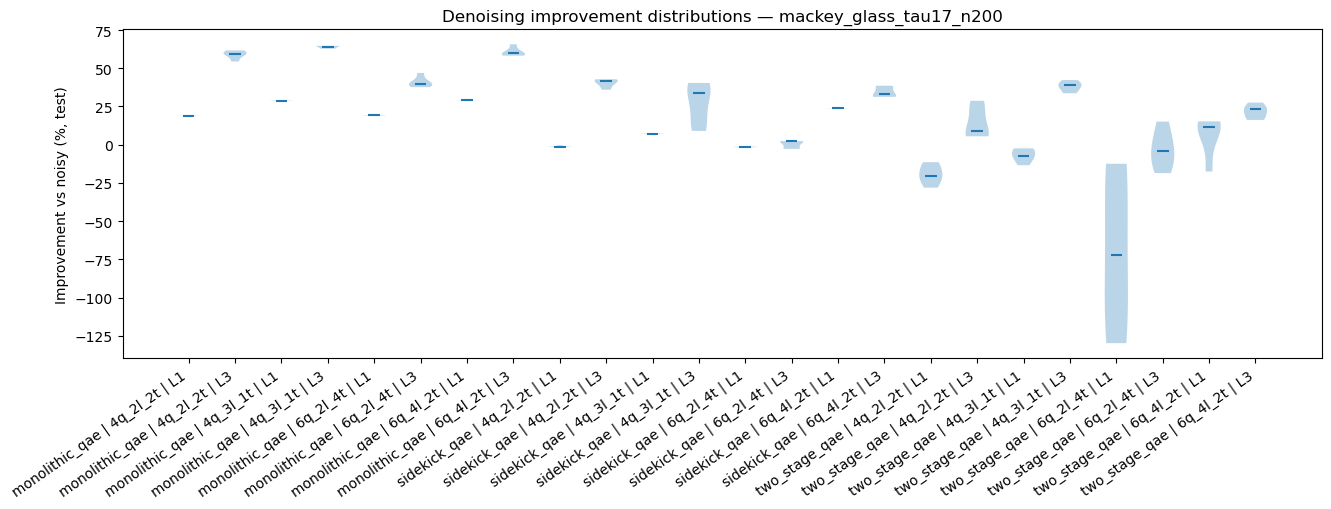

[mackey_glass_tau17_n200] Saved → qae_eval_framework/violin_improvement_mackey_glass_tau17_n200.png


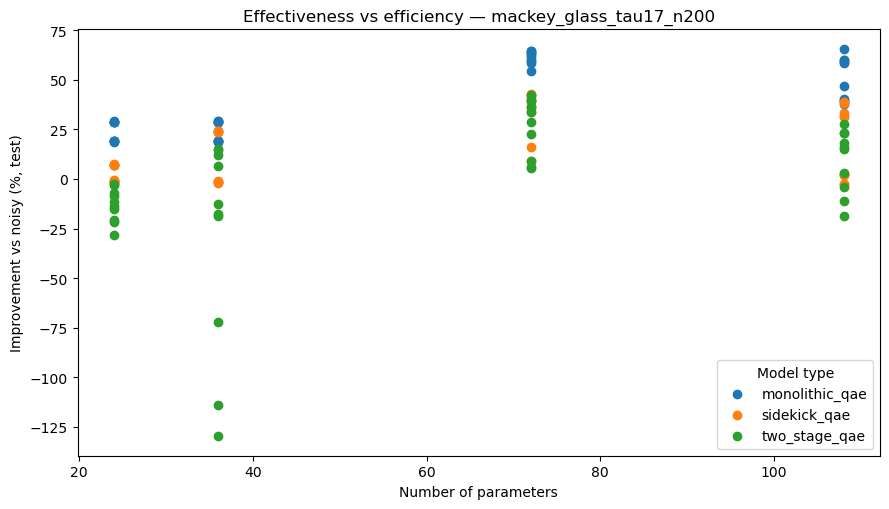

[mackey_glass_tau17_n200] Saved → qae_eval_framework/scatter_efficiency_mackey_glass_tau17_n200.png


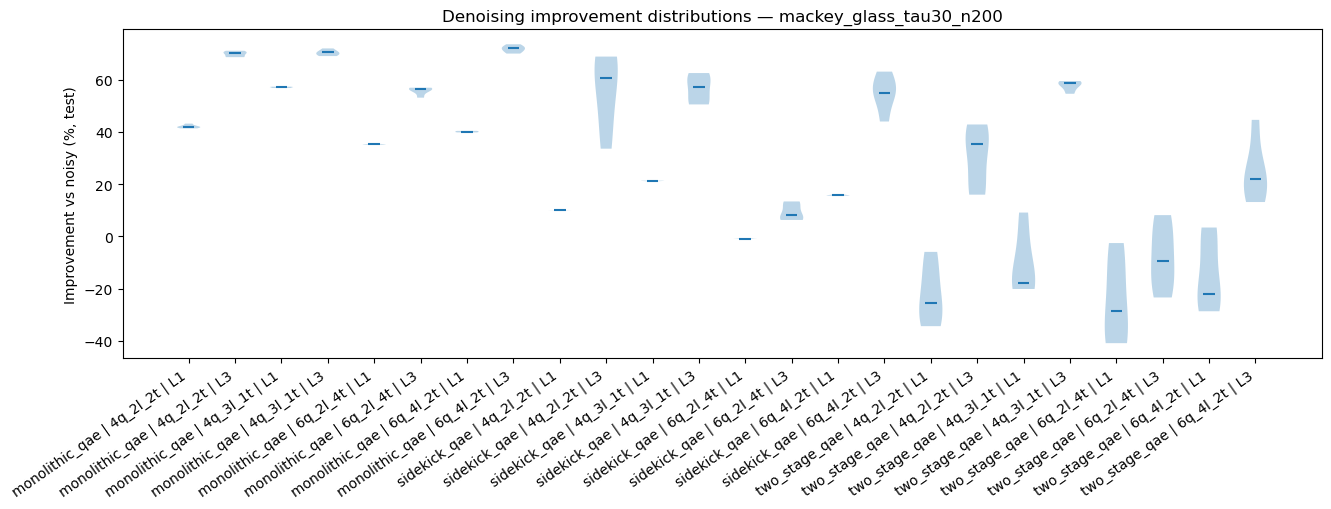

[mackey_glass_tau30_n200] Saved → qae_eval_framework/violin_improvement_mackey_glass_tau30_n200.png


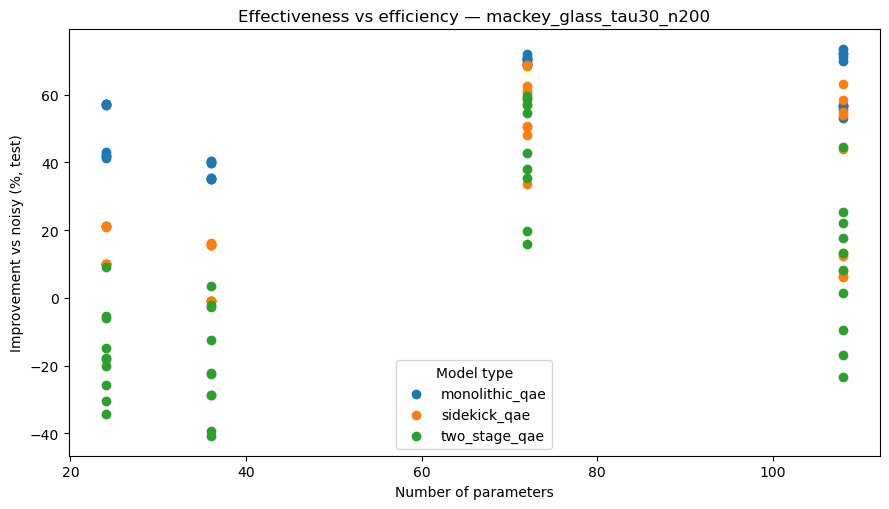

[mackey_glass_tau30_n200] Saved → qae_eval_framework/scatter_efficiency_mackey_glass_tau30_n200.png


In [114]:
# ===== Cell 8 — Plots =====
FRAMEWORK_OUT = Path("qae_eval_framework")

def _load_eval_csv(ds: str) -> pd.DataFrame:
    p = FRAMEWORK_OUT / f"eval_all_{ds}.csv"
    if not p.exists():
        print(f"[{ds}] No eval CSV found; skipping plots.")
        return pd.DataFrame()
    df = pd.read_csv(p)
    for c in ["imp_test_pct","mse_test_noise","mse_test_recovered","n_params_total"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def plot_violin_imp(df_all: pd.DataFrame, ds: str):
    if df_all.empty: 
        print(f"[{ds}] Nothing to plot (violin)."); 
        return
    df = df_all.copy()
    df["label"] = df["model_type"].astype(str) + " | " + df["arch_tag"].astype(str) + " | L" + df["layer"].astype(int).astype(str)

    groups, labels = [], []
    for lbl, g in df.groupby("label", dropna=False):
        vals = g["imp_test_pct"].dropna().values
        if len(vals): 
            groups.append(vals); labels.append(lbl)
    if not groups:
        print(f"[{ds}] No groups for violin."); return

    fig, ax = plt.subplots(figsize=(13.5, 5.2))
    ax.violinplot(groups, showextrema=False, showmedians=True)
    ax.set_xticks(np.arange(1, len(labels)+1), labels, rotation=35, ha="right")
    ax.set_ylabel("Improvement vs noisy (%, test)")
    ax.set_title(f"Denoising improvement distributions — {ds}")
    fig.tight_layout()
    out_png = FRAMEWORK_OUT / f"violin_improvement_{ds}.png"
    fig.savefig(out_png, dpi=200, bbox_inches="tight")
    plt.show()
    print(f"[{ds}] Saved → {out_png}")

def plot_effectiveness_vs_params(df_all: pd.DataFrame, ds: str):
    df = df_all.dropna(subset=["n_params_total","imp_test_pct"]).copy()
    if df.empty:
        print(f"[{ds}] Nothing to plot (scatter)."); return
    fig, ax = plt.subplots(figsize=(9.0, 5.2))
    for mtype, g in df.groupby("model_type", dropna=False):
        ax.scatter(g["n_params_total"].values, g["imp_test_pct"].values, label=mtype)
    ax.set_xlabel("Number of parameters")
    ax.set_ylabel("Improvement vs noisy (%, test)")
    ax.set_title(f"Effectiveness vs efficiency — {ds}")
    ax.legend(title="Model type")
    fig.tight_layout()
    out_png = FRAMEWORK_OUT / f"scatter_efficiency_{ds}.png"
    fig.savefig(out_png, dpi=200, bbox_inches="tight")
    plt.show()
    print(f"[{ds}] Saved → {out_png}")

for ds in DATASETS:
    df_all = _load_eval_csv(ds)
    if df_all.empty: 
        continue
    plot_violin_imp(df_all, ds)
    plot_effectiveness_vs_params(df_all, ds)

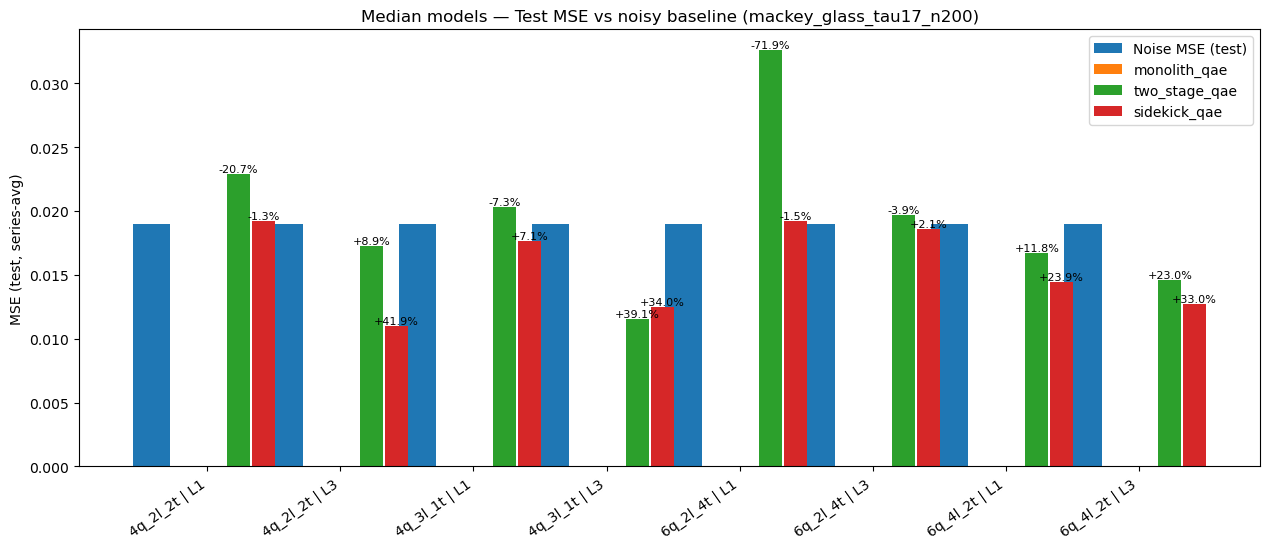

[mackey_glass_tau17_n200] Saved → qae_eval_framework/bar_median_testMSE_mackey_glass_tau17_n200.png


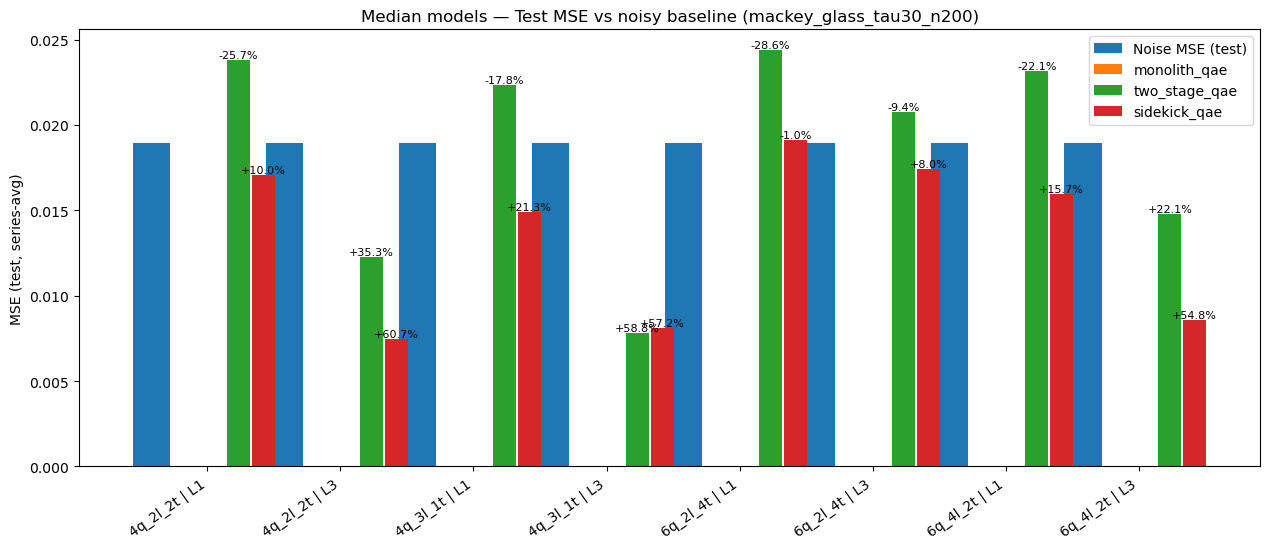

[mackey_glass_tau30_n200] Saved → qae_eval_framework/bar_median_testMSE_mackey_glass_tau30_n200.png


In [115]:
# ===== Cell 8b — Bar: Median models, test MSE vs noisy baseline, by model type =====
FRAMEWORK_OUT = Path("qae_eval_framework")

def _median_rows(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for (mtype, arch, L), g in df.groupby(["model_type","arch_tag","layer"], dropna=False):
        g2 = g.sort_values("imp_test_pct")
        if len(g2): rows.append(g2.iloc[len(g2)//2])
    return pd.DataFrame(rows).reset_index(drop=True)

ALLOWED_TYPES = {"monolith_qae","two_stage_qae","sidekick_qae"}

for ds in DATASETS:
    src = FRAMEWORK_OUT / f"eval_all_{ds}.csv"
    if not src.exists():
        print(f"[{ds}] No eval CSV; skipping.")
        continue
    df_all = pd.read_csv(src)
    if df_all.empty:
        print(f"[{ds}] eval empty; skipping.")
        continue

    # filter to allowed types only
    df_all = df_all[df_all["model_type"].isin(ALLOWED_TYPES)].copy()

    dfm = _median_rows(df_all)
    if dfm.empty:
        print(f"[{ds}] No median rows; skipping.")
        continue

    dfm["label"] = dfm["arch_tag"].astype(str) + " | L" + dfm["layer"].astype(int).astype(str)
    labels = sorted(dfm["label"].unique(), key=lambda s: (int(s.split("q_")[0]), s))
    x = np.arange(len(labels))
    width = 0.28

    base = []
    for lbl in labels:
        rows = dfm[dfm["label"] == lbl]
        base.append(np.nanmean(pd.to_numeric(rows["mse_test_noise"], errors="coerce")))
    base = np.array(base)

    # Only these three series
    order = ["monolith_qae","two_stage_qae","sidekick_qae"]

    fig, ax = plt.subplots(figsize=(12.8, 5.6))
    ax.bar(x - width, base, width, label="Noise MSE (test)")

    for idx, mtype in enumerate(order):
        offset = (-0.5 + (idx+1)/len(order)) * width * 2
        g = dfm[dfm["model_type"] == mtype].set_index("label")
        vals = np.array([pd.to_numeric(g["mse_test_recovered"].get(lbl, np.nan), errors="coerce") for lbl in labels])
        ax.bar(x + offset + width, vals, width/1.6, label=mtype)

        imps = [pd.to_numeric(g["imp_test_pct"].get(lbl, np.nan), errors="coerce") for lbl in labels]
        for i, (v, imp) in enumerate(zip(vals, imps)):
            if np.isfinite(v) and np.isfinite(imp):
                ax.text(x[i] + offset + width, v, f"{imp:+.1f}%", ha="center", va="bottom", fontsize=8)

    ax.set_xticks(x + width/2, labels, rotation=35, ha="right")
    ax.set_ylabel("MSE (test, series-avg)")
    ax.set_title(f"Median models — Test MSE vs noisy baseline ({ds})")
    ax.legend()
    fig.tight_layout()
    out_png = FRAMEWORK_OUT / f"bar_median_testMSE_{ds}.png"
    fig.savefig(out_png, dpi=220, bbox_inches="tight")
    plt.show()
    print(f"[{ds}] Saved → {out_png}")